# **Using the Final Model**
Here we experiment with using the trained model to guide a flight purchase and explain how two different flights may differ

In [ ]:
# Change CWD to repo base for imports
import os
from pathlib import Path
notebook_path = Path().resolve()
parent_directory = notebook_path.parent
if notebook_path.cwd().__str__().split("/")[-1] != "theory_of_ml_group4":
    os.chdir(parent_directory)

import matplotlib.pyplot as plt

# library imports
from etl import get_flight_data
from models import FlightPerformanceModel
import constants as c
# computation
import pandas as pd
import numpy as np
# model utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
# models
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from catboost import CatBoostClassifier, CatBoostRegressor

import logging
log = logging.getLogger("modeling")
log.setLevel(logging.INFO)

# use this for dev
# from importlib import reload
# import models
# reload(models)
# from models import FlightPerformanceModel

In [2]:
df = get_flight_data(sample_frac=0.10)
df_train, df_test = train_test_split(df, test_size=0.1, random_state=42)

reading data/202312_flights.csv
reading data/202307_flights.csv
reading data/202402_flights.csv
reading data/202209_flights.csv
reading data/202302_flights.csv
reading data/202210_flights.csv
reading data/202308_flights.csv
reading data/202404_flights.csv
reading data/202301_flights.csv
skipped data/state_region_map.csv
reading data/202401_flights.csv
skipped data/airport_id_map_old.csv
reading data/202304_flights.csv
reading data/202311_flights.csv
reading data/202406_flights.csv
reading data/202211_flights.csv
reading data/202303_flights.csv
reading data/202208_flights.csv
reading data/202403_flights.csv
reading data/202306_flights.csv
skipped data/airport_id_map.csv
reading data/202310_flights.csv
reading data/202305_flights.csv
reading data/202212_flights.csv
skipped data/airline_codes_map.csv
reading data/202405_flights.csv
reading data/202309_flights.csv
reading data/202207_flights.csv


## **Training the final model**

In [66]:
TRAIN_FRAC = 1.0

model = FlightPerformanceModel(
    targets={
        c.CANCELLED_COL: {
            "type": "classification",
            "estimator": CatBoostClassifier,
            "params": {"random_state": 42, "verbose": False}
        },
        c.DELAYED_COL: {
            "type": "classification",
            "estimator": CatBoostClassifier,
            "params": {"random_state": 42, "verbose": False}
        },
        c.DELAY_DURATION_COL: {
            "type": "regression",
            "estimator": CatBoostRegressor,
            "params": {"random_state": 42, "verbose": False}
        },
    },
)

# Uses 100 trees
# model = FlightPerformanceModel(
#     targets={
#         c.CANCELLED_COL: {
#             "type": "classification",
#             "estimator": RandomForestClassifier,
#             "params": {"n_jobs": -1, "random_state": 42}
#         },
#         c.DELAYED_COL: {
#             "type": "classification",
#             "estimator": RandomForestClassifier,
#             "params": {"n_jobs": -1, "random_state": 42}
#         },
#         c.DELAY_DURATION_COL: {
#             "type": "regression",
#             "estimator": RandomForestRegressor,
#             "params": {"n_jobs": -1, "random_state": 42}
#         },
#     },
# )

model.fit(df_train.sample(frac=TRAIN_FRAC, random_state=42))

Number of train rows with NaN: 1
Number of train rows with NaN: 1
21:55:07:Training model for target Cancelled
21:55:07:Training model for target Cancelled
21:55:49:Model for target Cancelled trained.
21:55:49:Model for target Cancelled trained.
21:55:49:Training model for target ArrDel15
21:55:49:Training model for target ArrDel15
21:56:31:Model for target ArrDel15 trained.
21:56:31:Model for target ArrDel15 trained.
21:56:31:Training model for target ArrDelay
21:56:31:Training model for target ArrDelay
21:56:38:Model for target ArrDelay trained.
21:56:38:Model for target ArrDelay trained.


In [67]:
df_test = df_test.dropna(subset=model.feature_base_cols)

# Predict probabilities and calculate AUC for logistic regression model
for target_col in [c.CANCELLED_COL, c.DELAYED_COL]:
    y_pred_proba = model.predict_proba(df_test, target_col=target_col)
    logistic_auc = roc_auc_score(df_test[target_col].fillna(0), y_pred_proba)
    print(f"Logistic Regression AUC for {target_col}: {logistic_auc:.4f} vs. 0.50 baseline")

# Predict delay duration and calculate RMSE for linear regression model
y_true_delay_duration = df_test.loc[df_test[c.DELAYED_COL] == 1.0][c.DELAY_DURATION_COL].fillna(0)
y_pred_delay_duration = model.predict(df_test.loc[(df_test[c.DELAYED_COL] == 1.0).values], target_col=c.DELAY_DURATION_COL)
linear_rmse = np.sqrt(np.mean((df_test.loc[df_test[c.DELAYED_COL] == 1.0][c.DELAY_DURATION_COL] - y_pred_delay_duration)**2))
baseline_rmse = np.sqrt(np.mean(df_test.loc[df_test[c.DELAYED_COL] == 1.0][c.DELAY_DURATION_COL]**2))
print(f"Linear Regression RMSE for {c.DELAY_DURATION_COL}: {linear_rmse:.4f} vs. {baseline_rmse:.4f} baseline")

Logistic Regression AUC for Cancelled: 0.7875 vs. 0.50 baseline
Logistic Regression AUC for ArrDel15: 0.6837 vs. 0.50 baseline
Linear Regression RMSE for ArrDelay: 103.7706 vs. 126.0831 baseline


## **Choosing between flights**

In [40]:
from datetime import date
DATA_PATH = Path() / "data"
AIRLINE_CODES_FILENAME = "airline_codes_map.csv"
AIRPORT_CODES_FILENAME = "airport_id_map.csv"

def preprocess_flight_metadata(df_prediction):
    airport_id_map = pd.read_csv(DATA_PATH / AIRPORT_CODES_FILENAME)
    df_prediction = pd.merge(df_prediction, airport_id_map.rename(columns={col:f"Origin{col.replace("_", "")}" for col in airport_id_map.columns}), left_on="OriginIATACode", right_on="OriginIATACode")
    df_prediction = pd.merge(df_prediction, airport_id_map.rename(columns={col:f"Dest{col.replace("_", "")}" for col in airport_id_map.columns}), left_on="DestIATACode", right_on="DestIATACode")
    return df_prediction

df_prediction = preprocess_flight_metadata(
    pd.DataFrame(
        {
            "OriginIATACode":["JFK", "JFK", "EWR", "EWR"],
            "DestIATACode":["LAX", "LAX", "LAX", "LAX"],
            "Airline_Name":["Delta Air Lines Inc.", "Delta Air Lines Inc.", "United Air Lines Inc.", "United Air Lines Inc."],
            "Distance":[2469.0]*4,
            "ScheduledDurationMinutes":[6*60+20] * 4,
            "FlightDate":[date(2024, 12, 10), date(2024, 12, 11), date(2024, 12, 10), date(2024, 12, 11)],
            "CRSDepTime":["17:30:00", "06:00:00", "17:30:00", "06:00:00"],
        }
    )
)

df_prediction

,OriginIATACode,DestIATACode,Airline_Name,Distance,ScheduledDurationMinutes,FlightDate,CRSDepTime,OriginCode,OriginAirportName,OriginAirportCity,...,OriginAirportShortName,OriginRegion,OriginDivision,DestCode,DestAirportName,DestAirportCity,DestAirportState,DestAirportShortName,DestRegion,DestDivision
0,JFK,LAX,Delta Air Lines Inc.,2469.0,380,2024-12-10,17:30:00,12478,"New York, NY: John F. Kennedy International",New York,...,John F. Kennedy International,Northeast,Middle Atlantic,12892,"Los Angeles, CA: Los Angeles International",Los Angeles,CA,Los Angeles International,West,Pacific
1,JFK,LAX,Delta Air Lines Inc.,2469.0,380,2024-12-11,06:00:00,12478,"New York, NY: John F. Kennedy International",New York,...,John F. Kennedy International,Northeast,Middle Atlantic,12892,"Los Angeles, CA: Los Angeles International",Los Angeles,CA,Los Angeles International,West,Pacific
2,EWR,LAX,United Air Lines Inc.,2469.0,380,2024-12-10,17:30:00,11618,"Newark, NJ: Newark Liberty International",Newark,...,Newark Liberty International,Northeast,Middle Atlantic,12892,"Los Angeles, CA: Los Angeles International",Los Angeles,CA,Los Angeles International,West,Pacific
3,EWR,LAX,United Air Lines Inc.,2469.0,380,2024-12-11,06:00:00,11618,"Newark, NJ: Newark Liberty International",Newark,...,Newark Liberty International,Northeast,Middle Atlantic,12892,"Los Angeles, CA: Los Angeles International",Los Angeles,CA,Los Angeles International,West,Pacific


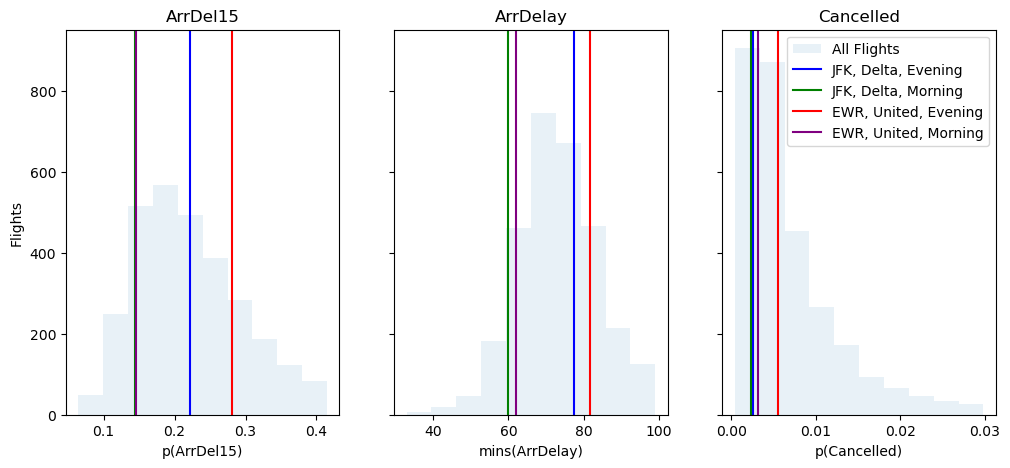

In [69]:
# Define the columns for subplots
columns = [c.DELAYED_COL, c.DELAY_DURATION_COL, c.CANCELLED_COL]

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True)

# Loop through the columns and create subplots
for n_col, (ax, col) in enumerate(zip(axes, columns)):
    mask = (df.Origin.isin(["EWR", "JFK"])) \
        & (df.Dest == "LAX")
    if col == c.DELAY_DURATION_COL:
        all_preds = model.predict(df.loc[mask], target_col=col,)
    else:
        all_preds = model.predict_proba(df.loc[mask], target_col=col,)
    all_preds = all_preds[all_preds < np.quantile(all_preds, 0.95)]
    
    ax.hist(
        all_preds,
        label="All Flights" if n_col == 2 else None,
        alpha=0.1,
    )

    preds = model.predict_on_time(df_prediction)
    flight_names = [
        "JFK, Delta, Evening",
        "JFK, Delta, Morning",
        "EWR, United, Evening",
        "EWR, United, Morning",
    ]
    for i, pred in preds.iterrows():
        ax.axvline(pred[col],
        label=flight_names[i] if n_col == 2 else None,
        color=["blue", "green", "red", "purple"][i])
    
    if n_col == 0:
        ax.set_ylabel("Flights")
    if n_col == 2:
        ax.legend()
    
    ax.set_title(col)
    ax.set_xlabel(f"{'p' if col != c.DELAY_DURATION_COL else "mins"}({col})")

  0%|          | 0/4 [00:00<?, ?it/s]

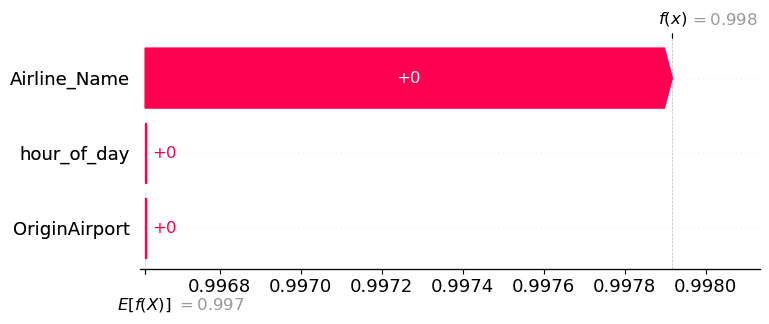

In [97]:
import shap
import pandas as pd
import numpy as np

# Assume you have a mapping of one-hot encoded features to their original categorical groups
# Transform test data (your step)
X_test = model._transform_to_df(df_prediction)

onehot_groups = {
    "Airline_Name": [col for col in X_test.columns if "Airline_Name" in col],
    "hour_of_day": [col for col in X_test.columns if "time_of_day" in col],
    "OriginAirport": [col for col in X_test.columns if "OriginAirport" in col],
}

shap.initjs()

# Calculate SHAP values for the test set
explainer = shap.KernelExplainer(model.estimators[c.CANCELLED_COL].predict_proba, X_test, link="identity")
shap_values = explainer.shap_values(X_test)

# Aggregate SHAP values by group
def group_shap_values(shap_values, feature_names, group_map):
    grouped_values = []
    grouped_names = []
    for group_name, feature_list in group_map.items():
        # Find indices of features in this group
        indices = [feature_names.index(f) for f in feature_list if f in feature_names]
        # Sum SHAP values for this group
        group_value = np.sum(shap_values[indices])
        grouped_values.append(group_value)
        grouped_names.append(group_name)
    return np.array(grouped_values), np.array(grouped_names)

# Select an instance to analyze
instance_index = 0  # Adjust as needed
target_class = 0    # Adjust as needed

# Extract SHAP values for the instance and group them
instance_shap_values = shap_values[instance_index][:, target_class]
grouped_values, grouped_names = group_shap_values(
    instance_shap_values, list(X_test.columns), onehot_groups
)

# Create a waterfall plot for grouped SHAP values
shap.waterfall_plot(
    shap.Explanation(
        values=grouped_values,
        base_values=explainer.expected_value[target_class],
        data=None,
        feature_names=grouped_names
    )
)


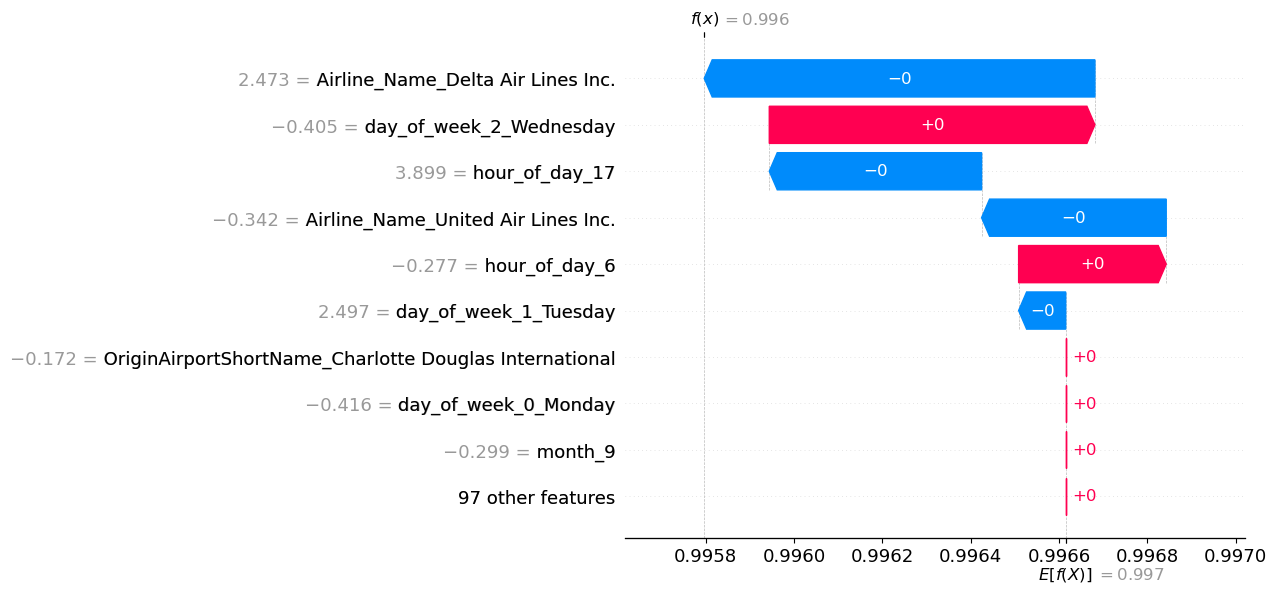

In [95]:
import shap

X_test = model._transform_to_df(df_prediction)

shap.initjs()
# Calculate SHAP values for the test set
explainer = shap.KernelExplainer(model.estimators[c.CANCELLED_COL].predict_proba, X_test, link="identity")


# # Summary plot of feature importance
# # https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/


# def combine_one_hot(shap_values, name, mask, return_original=True):
#     """  shap_values: an Explanation object
#           name: name of new feature
#           mask: bool array same lenght as features

#          This function assumes that shap_values[:, mask] make up a one-hot-encoded feature
#     """
#     mask = np.array(mask)
#     mask_col_names = np.array(shap_values.feature_names, dtype='object')[mask]

#     sv_name = shap.Explanation(shap_values.values[:, mask],
#                                feature_names=list(mask_col_names),
#                                data=shap_values.data[:, mask],
#                                base_values=shap_values.base_values,
#                                display_data=shap_values.display_data,
#                                instance_names=shap_values.instance_names,
#                                output_names=shap_values.output_names,
#                                output_indexes=shap_values.output_indexes,
#                                lower_bounds=shap_values.lower_bounds,
#                                upper_bounds=shap_values.upper_bounds,
#                                main_effects=shap_values.main_effects,
#                                hierarchical_values=shap_values.hierarchical_values,
#                                clustering=shap_values.clustering,
#                                )

#     new_data = (sv_name.data * np.arange(sum(mask))).sum(axis=1).astype(int)

#     svdata = np.concatenate([
#         shap_values.data[:, ~mask],
#         new_data.reshape(-1, 1)
#     ], axis=1)

#     if shap_values.display_data is None:
#         svdd = shap_values.data[:, ~mask]
#     else:
#         svdd = shap_values.display_data[:, ~mask]

#     svdisplay_data = np.concatenate([
#         svdd,
#         mask_col_names[new_data].reshape(-1, 1)
#     ], axis=1)

#     new_values = sv_name.values.sum(axis=1)
#     svvalues = np.concatenate([
#         shap_values.values[:, ~mask],
#         new_values.reshape(-1, 1)
#     ], axis=1)
#     svfeature_names = list(np.array(shap_values.feature_names)[~mask]) + [name]

#     sv = shap.Explanation(svvalues,
#                           base_values=shap_values.base_values,
#                           data=svdata,
#                           display_data=svdisplay_data,
#                           instance_names=shap_values.instance_names,
#                           feature_names=svfeature_names,
#                           output_names=shap_values.output_names,
#                           output_indexes=shap_values.output_indexes,
#                           lower_bounds=shap_values.lower_bounds,
#                           upper_bounds=shap_values.upper_bounds,
#                           main_effects=shap_values.main_effects,
#                           hierarchical_values=shap_values.hierarchical_values,
#                           clustering=shap_values.clustering,
#                           )
#     if return_original:
#         return sv, sv_name
#     else:
#         return sv

# sv = combine_one_hot(shap_values, 'hour_of_day', X_test.columns.str.contains("hour_of_day"))

# Select a single instance and target class for the waterfall plot
instance_index = 2  # First instance
target_class = 1   # Setosa class

# Create a waterfall plot
shap.waterfall_plot(
    shap_values[0, :, target_class]
    # shap.Explanation(values=shap_values[instance_index][:, target_class],
    #                  base_values=explainer.expected_value[target_class],
    #                  data=X_test.iloc[instance_index],
    #                  feature_names=X_test.columns)
)

In [98]:
df_shap = pd.DataFrame(shap_values[:, :, 0])
df_shap.columns = X_test.columns

In [99]:
df_shap[[col for col in df_shap.columns if "hour_of_day" in col]].sum(axis=1).sort_values(ascending=False)

2    0.000230
0    0.000147
3   -0.000170
1   -0.000206
dtype: float64